# Detectando o Invisível: Como a Análise de Dados Pode Prevenir Fraudes em Transações Bancárias
## Notebook 03 — Criação do Score de Risco e Avaliação

---

**Objetivo:** Transformar os insights encontrados nas Seções 3 (EDA) e 4 (Engenharia de Features) em um sistema de pontuação interpretável, capaz de classificar transações em níveis de risco de forma transparente, auditável e alinhada aos padrões de negócio, além de validar o desempenho atráves de métricas e Machine Learning.

**Entradas:** Base enriquecida (`df_features.csv`) e tabela consolidada de risco relativo das features derivadas (`consolidated_risk_table_derived_features`).\
**Saídas:** Tabela consolidada de pesos, tabela de performance por categoria, tabela de métricas de performance, tabela de impacto financeiro, gráficos e insights.

---

### Estrutura deste notebook

5. Construção do Score de Risco\
   5.1. Definição de Pesos\
   5.2. Aplicação e Categorização

6. Avaliação de Performance\
   6.1. Métricas de Performance\
   6.2. Matriz de Confusão\
   6.3. Validação com Machine Learning

7. Calibração Econômica\
   7.1 Lógica de Construção da Tabela de Impacto Financeiro\
   7.2 Construção da Tabela de Impacto Financeiro

8. Conclusão: Criação do Score de Risco e Avaliação

9. Conclusão do Projeto

### Importing the libraries

Carregando: ['pd', 'sns', 'plt', 'mpl', 'np', 'LogisticRegression', 'roc_auc_score', 'roc_curve', 'auc']
------------------------------
✅ pd (pandas)
✅ sns (seaborn)
✅ plt (matplotlib.pyplot)
✅ mpl (matplotlib)
✅ np (numpy)
✅ LogisticRegression (sklearn.linear_model.LogisticRegression)
✅ roc_auc_score (sklearn.metrics.roc_auc_score)
✅ roc_curve (sklearn.metrics.roc_curve)
✅ auc (sklearn.metrics.auc)

VERSÕES:
Python: 3.10.2
pandas: 2.2.2
seaborn: 0.13.2
matplotlib: 3.8.4
matplotlib: 3.8.4
numpy: 1.26.4
scikit-learn: 1.4.2
scikit-learn: 1.4.2
scikit-learn: 1.4.2
scikit-learn: 1.4.2

Bibliotecas disponíveis diretamente (IPython): ['pd', 'sns', 'plt', 'mpl', 'np', 'LogisticRegression', 'roc_auc_score', 'roc_curve', 'auc']


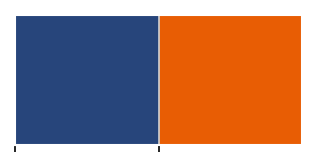

In [1]:
# Data manipulation and visualization.
import importlib
import sys
sys.path.append('../src')

from utils import lib_loader as libl
libl.carregar_libs(['pd','sns','plt','mpl','np','LogisticRegression','roc_auc_score', 'roc_curve', 'auc'])

from utils import threshold_analysis as thr
from models import information_value_iv as iv

pd.set_option('display.max_columns', None)

### Visualization Settings
%matplotlib inline

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.max_open_warning'] = 50

mpl.style.use('ggplot') 
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting and Display
color_palette = ['#27457B', '#e85d04']
sns.set_palette(sns.color_palette(color_palette))
sns.color_palette(color_palette)
sns.palplot(color_palette)

## Importação e Visão Geral

In [3]:
df = pd.read_csv('../data/processed/df_features.csv')
df.head()

,transaction_id,merchant_id,user_id,hash_card_number,transaction_date,transaction_amount,device_id,has_cbk,has_device_info,transaction_day,transaction_time,transaction_hour,part_of_day,day_of_week,is_weekend,first_transaction,time_diff_min,time_diff_less_1h,anomalous_value,value_exc_max,burst_transaction,multi_card_flag,multi_device_flag,user_fraud_above_50,comb_a,nighttime_flag
0,21320398,29744,97051,cn_225730bfed215e86fcb14e416783716d42c37eb87b0...,2019-12-01 23:16:32.812632,374.56,285475.0,0,1,2019-12-01,23:16:32.812632,23,Evening,Domingo,1,1,0.000000,1th transaction,0,0,0,0,0,0,0,1
1,21320399,92895,2708,cn_1026e63cb76b5fdaeab4f472b47236d4539cf48d2ec...,2019-12-01 22:45:37.873639,734.87,497105.0,1,1,2019-12-01,22:45:37.873639,22,Evening,Domingo,1,0,2624.721795,> 1h,0,1,0,0,0,0,0,1
2,21320400,47759,14777,cn_a44e42e0d67ad8cdac30990f2f1f8718c74a03c4d40...,2019-12-01 22:22:43.021495,760.36,unknown_device,0,0,2019-12-01,22:22:43.021495,22,Evening,Domingo,1,1,0.000000,1th transaction,0,0,0,0,0,0,0,1
3,21320401,68657,69758,cn_fa68ce07344577d64f20949a4aea6159020655897c7...,2019-12-01 21:59:19.797129,2556.13,unknown_device,1,0,2019-12-01,21:59:19.797129,21,Evening,Domingo,1,0,161.967766,> 1h,0,0,0,0,0,1,1,1
4,21320402,54075,64367,cn_3c6a38fd69a2ab71859017440efa3d722a97c209cf7...,2019-12-01 21:30:53.347051,55.36,860232.0,0,1,2019-12-01,21:30:53.347051,21,Evening,Domingo,1,1,0.000000,1th transaction,0,0,0,0,0,0,0,1


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 3199 rows and 26 columns.


### Data dictionary

| Variáveis Originais  |
|:---------------------|

| Variável           | Descrição                                         | Tipo                 |
|:-------------------|:--------------------------------------------------|:---------------------|
| transaction_id     | Identificador único da transação                  | String/ID            |
| merchant_id        | Identificador do estabelecimento comercial        | String/ID            |
| user_id            | Identificador do usuário que realizou a transação | String/ID            |
| hash_card_number   | Número do cartão usado (hash/anonimizado)         | String/ID            |
| transaction_date   | Data e hora da transação                          | DateTime             |
| transaction_amount | Valor monetário da transação (R$)                 | Numerical continuous |
| device_id          | Identificador do dispositivo usado na transação   | String/ID            |
| has_cbk            | Target: 1 = Fraude (chargeback), 0 = Legítimo     | Binary (0/1)         |

---

| Novas Variáveis    |
|:-------------------|

| Variável            | Descrição                                                                                    | Tipo                   |
|:--------------------|:---------------------------------------------------------------------------------------------|:-----------------------|
| has_device_info     | Indica se há informação de dispositivo disponível                                            | Binary (0/1)           |
| transaction_day     | Dia do mês em que a transação ocorreu                                                        | Numerical discrete     |
| transaction_time    | Horário completo da transação                                                                | Time                   |
| transaction_hour    | Hora do dia da transação (0–23)                                                              | Numerical discrete     |
| part_of_day         | Período do dia (madrugada, manhã, tarde, noite)                                              | Categorical            |
| day_of_week         | Dia da semana da transação                                                                   | Categorical            |
| is_weekend          | Indica se a transação ocorreu no fim de semana                                               | Binary (0/1)           |
| first_transaction   | Indica se é a primeira transação do usuário                                                  | Binary (0/1)           |
| time_diff_min       | Diferença de tempo (em minutos) para a transação anterior do usuário                         | Numerical continuous   |
| time_diff_less_1h   | Indica se a transação ocorreu em menos de 1h após a anterior                                 | Categorical            |
| anomalous_value     | Indica se o valor da transação é anômalo em relação ao histórico do usuário                  | Binary (0/1)           |
| value_exc_max       | Indica se o valor da transação excede o máximo histórico do usuário                          | Binary (0/1)           |
| burst_transaction   | Indica padrão de múltiplas transações em curto intervalo de tempo                            | Binary (0/1)           |
| multi_card_flag     | Indica uso de múltiplos cartões pelo mesmo usuário                                           | Binary (0/1)           |
| multi_device_flag   | Indica uso de múltiplos dispositivos pelo mesmo usuário                                      | Binary (0/1)           |
| user_fraud_above_50 | Indica se o usuário possui taxa histórica de fraude > 50%                                    | Binary (0/1)           |
| comb_a              | Combinação de 'alor alto' + 'horário noturno', capturando risco composto                     | Binary (0/1)           |
| nighttime_flag      | Indica se a transação ocorreu entre 19h e 3h                                                 | Binary (0/1)           |

# 5. Construção do Score de Risco <a id='construcao-do-score-de-risco'></a>

Devido ao tamanho reduzido do dataset, técnicas puras de machine learning correm alto risco de overfitting e tornam-se instáveis para seleção de features e atribuição de importância.

Por isso, adotamos a estratégia clássica de problemas com pouca amostra: construir um score manual baseado em evidências (Risco Relativo, Information Value e Correlação), e usar a Regressão Logística apenas como ferramenta de validação estrutural, verificando se os sinais aprendidos pelo modelo convergem com os pesos definidos manualmente.

**Desbalanceamento do Dataset:**

O dataset apresenta desbalanceamento entre transações legítimas e fraudulentas, o que é característico de problemas reais de detecção de fraude. Essa distribuição não compromete as análises realizadas, pois foram aplicadas métricas robustas à assimetria (AUC, F1, Recall) e a Regressão Logística foi ajustada com `class_weight='balanced'`.

Além disso, como o objetivo do projeto é comparar pesos manuais com um modelo estatístico e construir um score interpretável, e não treinar um modelo preditivo complexo, o desbalanceamento não afeta negativamente a validade dos resultados.

## 5.1. Definição de Pesos

Vamos atribuir um peso numérico para cada feature derivada, baseado nos indicadores-chave: Information Value (IV), Risco Relativo e na correlação entre elas. 

A combinação desses três indicadores nos permite distinguir força real (IV), redundância (correlação) e intensidade bruta do risco (RR).
Assim, chegamos a uma atribuição de pesos mais estável, interpretável e tecnicamente fundamentada, garantindo que features mais preditivas tenham maior influência no score final.

### **5.1.1. Cálculo do Information Value - IV**

Utilizaremos o IV como métrica, pois é amplamente utilizada na construção de scorecards (crédito, fraude, cobrança), devido quantificar o poder de discriminação de uma variável, independentemente de escalas ou relações lineares.

In [5]:
df_features = df[['has_cbk',
                  'user_fraud_above_50', 
                  'multi_card_flag', 	
                  'burst_transaction',
                  'value_exc_max', 	
                  'multi_device_flag',
                  'comb_a',
                  'anomalous_value',
                  'nighttime_flag']]

In [6]:
iv_results = iv.calc_iv_all(df_features, target='has_cbk')

iv_results['weight_iv'] = pd.cut(
    iv_results['iv'],
    bins=[-np.inf, 0.50, 1.50, np.inf],
    labels=[1, 2, 3]
).astype(int)

iv_results

,feature,iv,definition,weight_iv
0,user_fraud_above_50,2.732667,"> 0,5: Muito forte (requer atenção)",3
1,multi_card_flag,1.233462,"> 0,5: Muito forte (requer atenção)",2
2,burst_transaction,1.104064,"> 0,5: Muito forte (requer atenção)",2
3,value_exc_max,0.415118,"0,3–0,5: Forte",1
4,multi_device_flag,0.310375,"0,3–0,5: Forte",1
5,comb_a,0.236182,"0,1–0,3: Médio",1
6,nighttime_flag,0.175281,"0,1–0,3: Médio",1
7,anomalous_value,0.165741,"0,1–0,3: Médio",1


O IV é usado aqui como critério relativo de ajuste, não absoluto.\
Em datasets pequenos, valores de IV tendem a inflar, portanto, adotamos uma escala adaptada para ranqueamento entre features:

- IV ≥ 1.5 = 3
- 0.5 ≤ IV < 1.5 = 2
- IV < 0.5 = 1

### **5.1.2. Cálculo de peso via Risco Relativo**

Utilizaremos o Risco Relativo como métrica, pois captura a gravidade do comportamento, não apenas capacidade preditiva.

In [7]:
rt_features = pd.read_csv('../data/interim/consolidated_risk_table_derived_features.csv')
rt_features.head(8)

,feature,bin,n_total,n_has_cbk,has_cbk_rate,relative_risk,priority
0,user_fraud_above_50,1,237,215,90.7%,7.42,CRÍTICA
1,multi_card_flag,1,192,144,75.0%,6.14,CRÍTICA
2,multi_device_flag,1,68,46,67.6%,5.53,CRÍTICA
3,burst_transaction,1,300,172,57.3%,4.69,CRÍTICA
4,comb_a,1,98,50,51.0%,4.17,CRÍTICA
5,value_exc_max,1,191,91,47.6%,3.90,CRÍTICA
6,anomalous_value,1,223,70,31.4%,2.57,CRÍTICA
7,nighttime_flag,1,1405,243,17.3%,1.42,BAIXA


In [8]:
stats_df_rr = rt_features[['feature', 'relative_risk']].head(8)

stats_df_rr['weight_rr'] = pd.cut(
    stats_df_rr['relative_risk'],
    bins=[-np.inf, 4.00, 6.00, np.inf],
    labels=[1, 2, 3]
).astype(int)

stats_df_rr

,feature,relative_risk,weight_rr
0,user_fraud_above_50,7.42,3
1,multi_card_flag,6.14,3
2,multi_device_flag,5.53,2
3,burst_transaction,4.69,2
4,comb_a,4.17,2
5,value_exc_max,3.90,1
6,anomalous_value,2.57,1
7,nighttime_flag,1.42,1


Transformamos o Risco Relativo em um “peso bruto” usando a seguinte regra:

- RR ≥ 6 = 3
- 4 ≤ RR < 6 = 2
- RR < 4 = 1

#### **Tabela consolidada - IV + RR**

In [9]:
rr_merge = stats_df_rr[['feature', 'relative_risk', 'weight_rr']]
rr_iv = iv_results[['feature', 'iv', 'weight_iv']]
stats_df_iv_rr = pd.merge(rr_iv, rr_merge, on='feature', how='inner')
stats_df_iv_rr

,feature,iv,weight_iv,relative_risk,weight_rr
0,user_fraud_above_50,2.732667,3,7.42,3
1,multi_card_flag,1.233462,2,6.14,3
2,burst_transaction,1.104064,2,4.69,2
3,value_exc_max,0.415118,1,3.90,1
4,multi_device_flag,0.310375,1,5.53,2
5,comb_a,0.236182,1,4.17,2
6,nighttime_flag,0.175281,1,1.42,1
7,anomalous_value,0.165741,1,2.57,1


### **5.1.3. Análise de Correlação**

Utilizaremos a Correlação como métrica, pois evita pesos duplicados devido sua capacidade de identificar variáveis que capturam o mesmo padrão.

#### **Matriz de Correlação**

In [10]:
corr_matrix = df_features.corr()

In [11]:
corr_matrix['has_cbk'].sort_values(ascending=False)

has_cbk                1.000000
user_fraud_above_50    0.677875
multi_card_flag        0.484300
burst_transaction      0.443041
value_exc_max          0.272503
multi_device_flag      0.249369
comb_a                 0.210570
anomalous_value        0.160188
nighttime_flag         0.137057
Name: has_cbk, dtype: float64

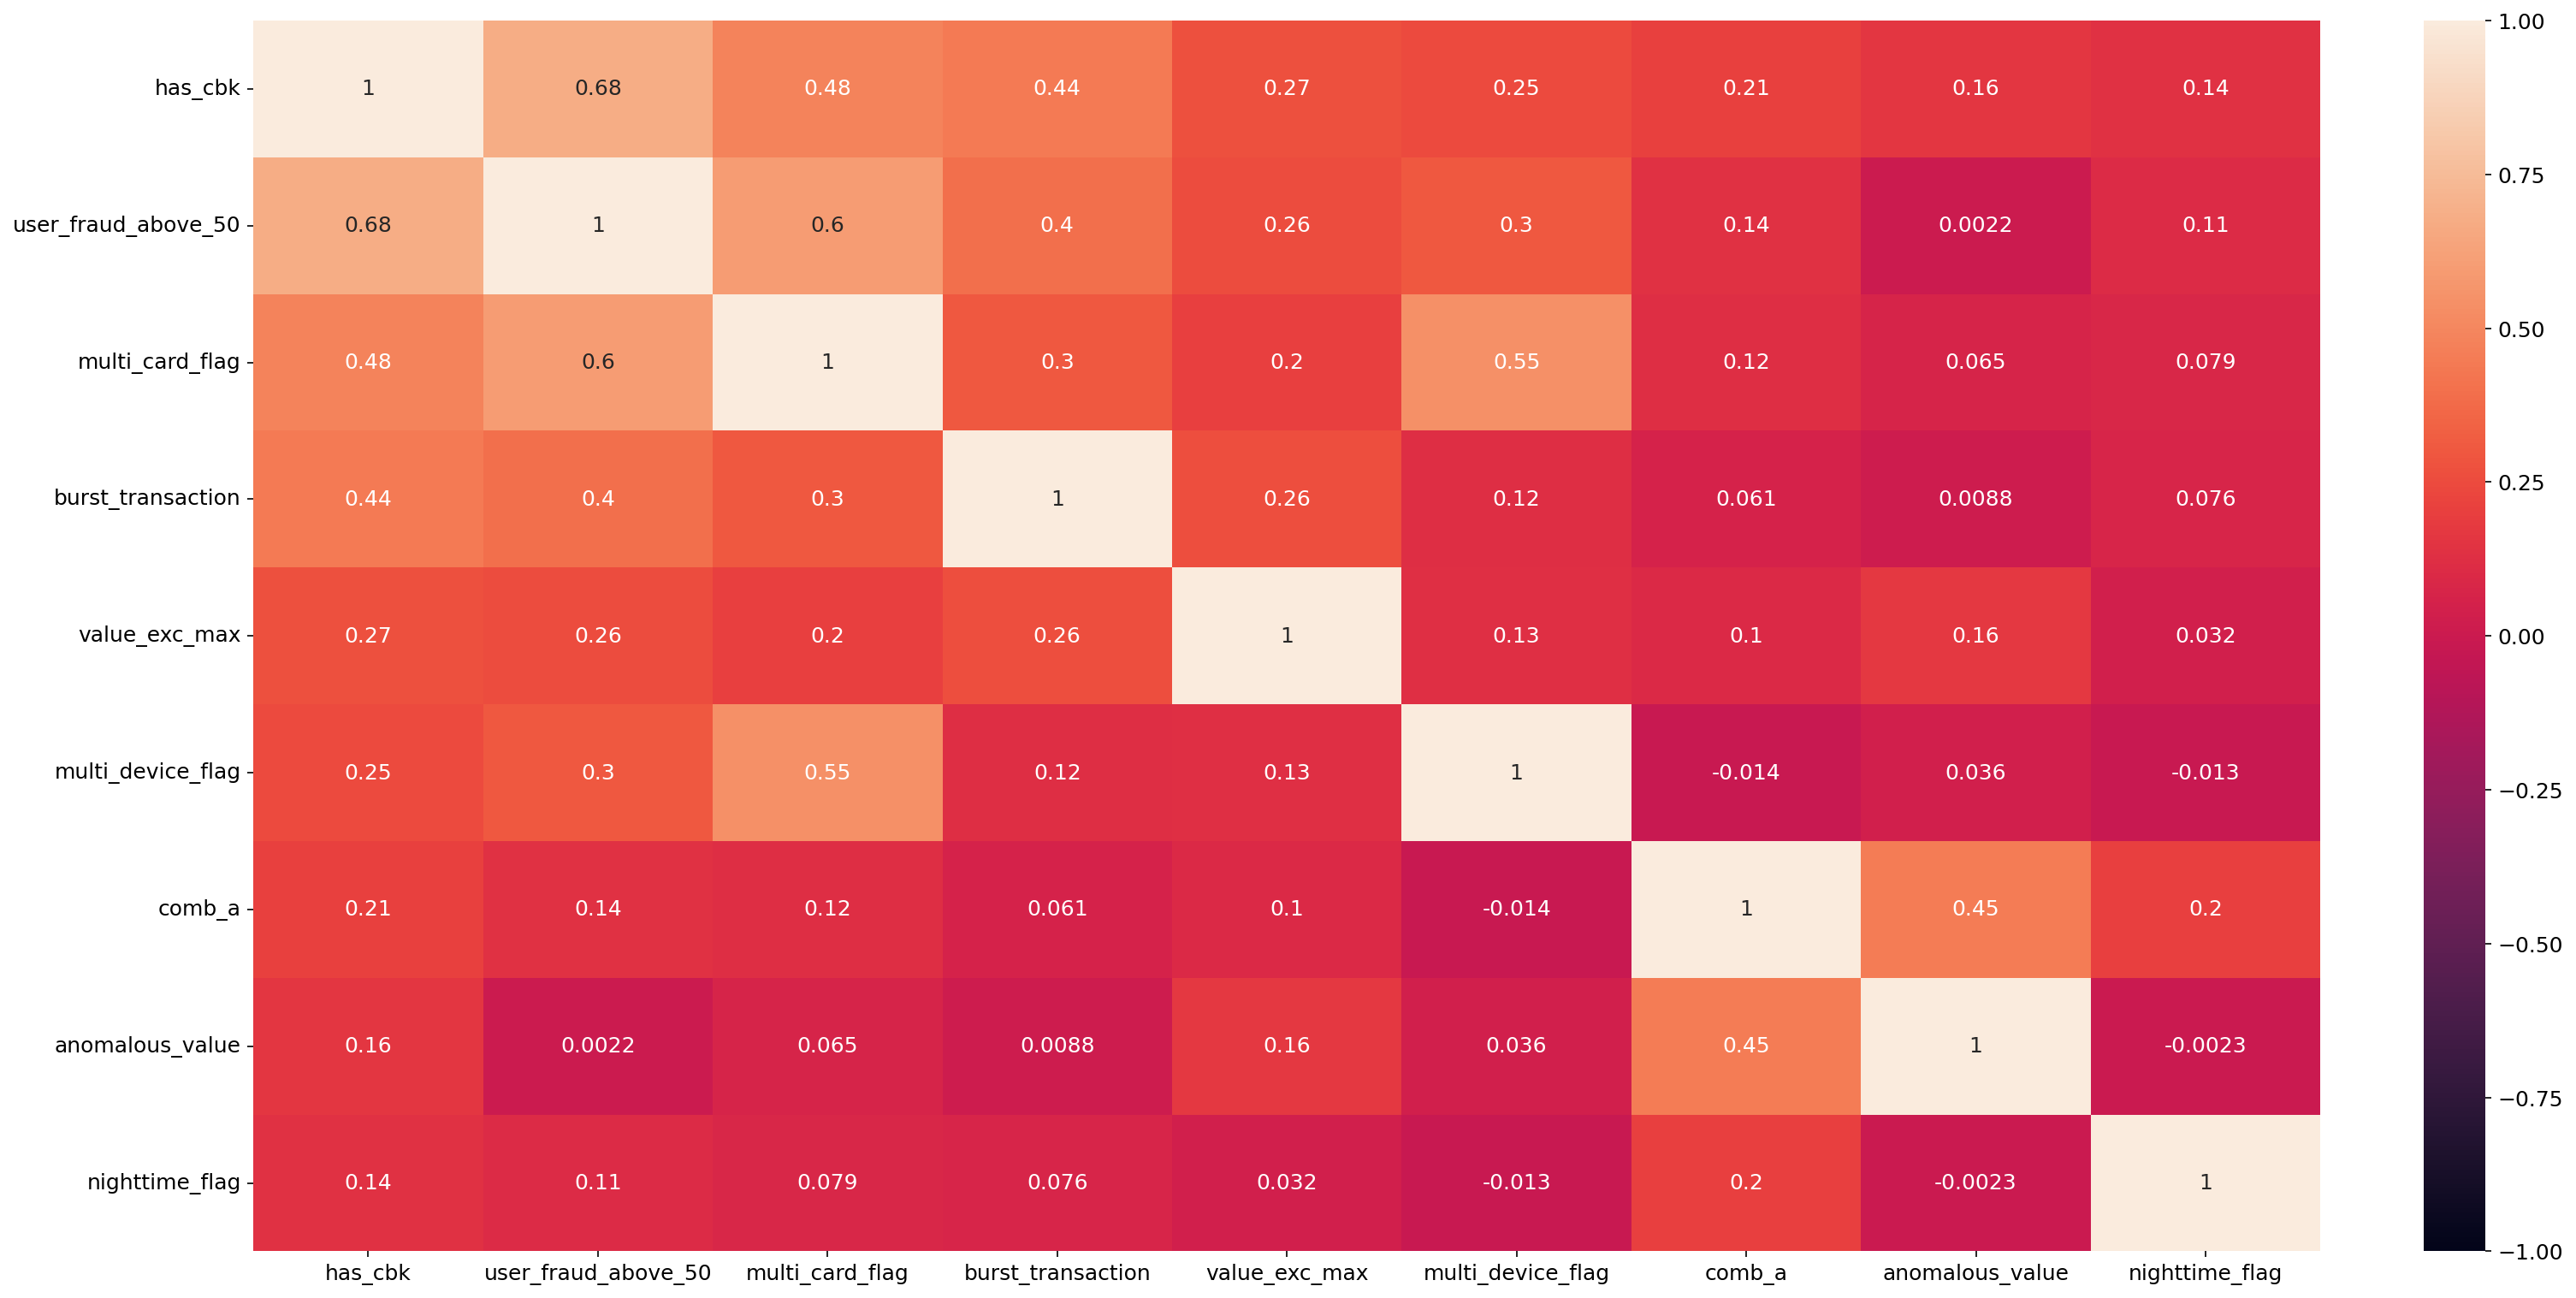

In [12]:
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)
plt.show()

#### **Coluna de Penalidade baseada na Matriz de Correlação**

Como anteriormente falado, a matriz de correlação nos permite identificar redundância entre features. Dessa forma, utilizaremos a seguinte regra:

- Se uma feature é altamente correlacionada (>|0.5|) com outra mais forte (maior IV), ela perde 1 ponto de peso.

Assim, evitamos dupla contagem do mesmo comportamento de risco.

In [27]:
stats_df_iv_rr_corr = stats_df_iv_rr.copy()
stats_df_iv_rr_corr["corr_val"] = 0.0 
stats_df_iv_rr_corr["corr_penalty"] = 0

corr_matrix_features = df[stats_df_iv_rr["feature"]].corr()

ordered_features = stats_df_iv_rr_corr.sort_values("iv", ascending=False)["feature"].tolist()

processed = []

for feat in ordered_features:
    idx = stats_df_iv_rr_corr[stats_df_iv_rr_corr["feature"] == feat].index[0]
    max_corr_val = 0.0
    actual_max_corr = 0.0

    for other in processed:
        corr_val = corr_matrix_features.loc[feat, other]
        abs_corr_val = abs(corr_val)
        
        if abs_corr_val > max_corr_val:
            max_corr_val = abs_corr_val
            actual_max_corr = corr_val

        if abs_corr_val >= 0.5:
            stats_df_iv_rr_corr.loc[idx, "corr_penalty"] = -1
            break

    stats_df_iv_rr_corr.loc[idx, "corr_val"] = actual_max_corr
    
    processed.append(feat)

stats_df_iv_rr_corr

,feature,iv,weight_iv,relative_risk,weight_rr,corr_val,corr_penalty
0,user_fraud_above_50,2.732667,3,7.42,3,0.000000,0
1,multi_card_flag,1.233462,2,6.14,3,0.596839,-1
2,burst_transaction,1.104064,2,4.69,2,0.396208,0
3,value_exc_max,0.415118,1,3.90,1,0.262882,0
4,multi_device_flag,0.310375,1,5.53,2,0.546718,-1
5,comb_a,0.236182,1,4.17,2,0.136717,0
6,nighttime_flag,0.175281,1,1.42,1,0.200879,0
7,anomalous_value,0.165741,1,2.57,1,0.449968,0


### **5.1.4. Tabela Consolidade de Pesos**

O peso final combina: peso do IV, peso do RR e penalidade por correlação.

Optamos por trabalhar com três níveis de peso (1, 2 e 3) por serem suficientes para distinguir a força das features.\
Isso garante interpretabilidade, estabilidade estatística e alinhamento com práticas clássicas de scorecards em problemas de fraude e crédito, além de facilitar a comparação posterior com os coeficientes da Regressão Logística.

In [14]:
stats_df = stats_df_iv_rr_corr.copy()
stats_df['weight_score_manual'] = stats_df['weight_rr'] + stats_df['weight_iv'] + stats_df['corr_penalty']
stats_df['weight_score_manual_ajustado'] = (stats_df['weight_score_manual']/2).apply(np.ceil).astype(int)
stats_df

,feature,iv,weight_iv,relative_risk,weight_rr,corr_val,corr_penalty,weight_score_manual,weight_score_manual_ajustado
0,user_fraud_above_50,2.732667,3,7.42,3,0.000000,0,6,3
1,multi_card_flag,1.233462,2,6.14,3,0.596839,-1,4,2
2,burst_transaction,1.104064,2,4.69,2,0.396208,0,4,2
3,value_exc_max,0.415118,1,3.90,1,0.262882,0,2,1
4,multi_device_flag,0.310375,1,5.53,2,0.546718,-1,2,1
5,comb_a,0.236182,1,4.17,2,0.136717,0,3,2
6,nighttime_flag,0.175281,1,1.42,1,0.200879,0,2,1
7,anomalous_value,0.165741,1,2.57,1,0.449968,0,2,1


#### **Lógica de Atribuição**

- `weight_iv`: Pesos definidos a partir do IV calculado na Seção 5.1.1.
- `weight_rr`: Pesos definidos a partir do Risco Relativo calculado na Seção 5.1.2.
- `weight_score_manual`: `weight_iv` + `weight_rr` + `corr_penalty`
- `weight_score_manual_ajustado`: Para manter uma escala simples (1–3) e preservar interpretabilidade, dividimos o resultado de `weight_score_manual` por 2 e arrendodamos para cima.

Dessa forma:
- Features de maior discriminação recebem maior peso.
- Correlações e redundâncias foram consideradas para evitar sobrepeso indevido.

Em resumo, a estrutura de pesos atual é robusta para esta primeira versão do score, refletindo corretamente a importância relativa de cada feature.

Na Seção 5.2, 6 e 7, validaremos formalmente essa escolha por meio de:\
Métricas de performance, Regressão Logística e Avaliação financeira por threshold.

Essas etapas irão mostrar se os pesos atuais já são ótimos ou se ajustes finos podem melhorar ainda mais o desempenho do modelo.

## 5.2. Aplicação e Categorização

Iremos realizar o cálculo aplicando os pesos encontrados, criando a coluna auxiliar `weight_score`, analisando o desempenho do nosso modelo de 'score manual' na captura de fraudes.\
Posteriormente, atráves da categorização, definiremos ações para cada faixa definida.

### **5.2.1. Cálculo e distribuição do Score**

In [15]:
# Cálculo do Score

df['weight_score'] = (
    df['user_fraud_above_50'] * 3 + 
	df['multi_card_flag'] * 2 + 	
    df['burst_transaction'] * 2 + 
    df['comb_a'] * 2 + 	
	df['multi_device_flag'] * 1 + 	
	df['value_exc_max'] * 1 + 	
	df['anomalous_value'] * 1 +
    df['nighttime_flag'] * 1
)

In [16]:
# Distribuição do Score

agg_table = df.groupby('weight_score')['has_cbk'].agg(
    # Coluna 1: n_transactions
    n_transactions='size', 
    # Coluna 2: n_frauds
    n_frauds='sum',   
    # Coluna 3: fraud_rate
    fraud_rate='mean'   
).reset_index()

# Coluna 4: relative_freq
total_transactions = len(df)
agg_table['relative_freq'] = ((agg_table['n_transactions'] / total_transactions) * 100).round(1)

# Coluna 5: cumulative_freq
agg_table['cumulative_freq'] = agg_table['relative_freq'].cumsum().round(1)

# Renomear as colunas e formatar a taxa de fraude
agg_table = agg_table.rename(columns={'weight_score': 'score'})
agg_table['fraud_rate'] = (agg_table['fraud_rate'] * 100).round(1)

agg_table

,score,n_transactions,n_frauds,fraud_rate,relative_freq,cumulative_freq
0,0,1458,22,1.5,45.6,45.6
1,1,1189,63,5.3,37.2,82.8
2,2,92,13,14.1,2.9,85.7
3,3,108,33,30.6,3.4,89.1
4,4,104,45,43.3,3.3,92.4
5,5,56,46,82.1,1.8,94.2
6,6,66,54,81.8,2.1,96.3
7,7,54,48,88.9,1.7,98.0
8,8,50,46,92.0,1.6,99.6
9,9,12,12,100.0,0.4,100.0


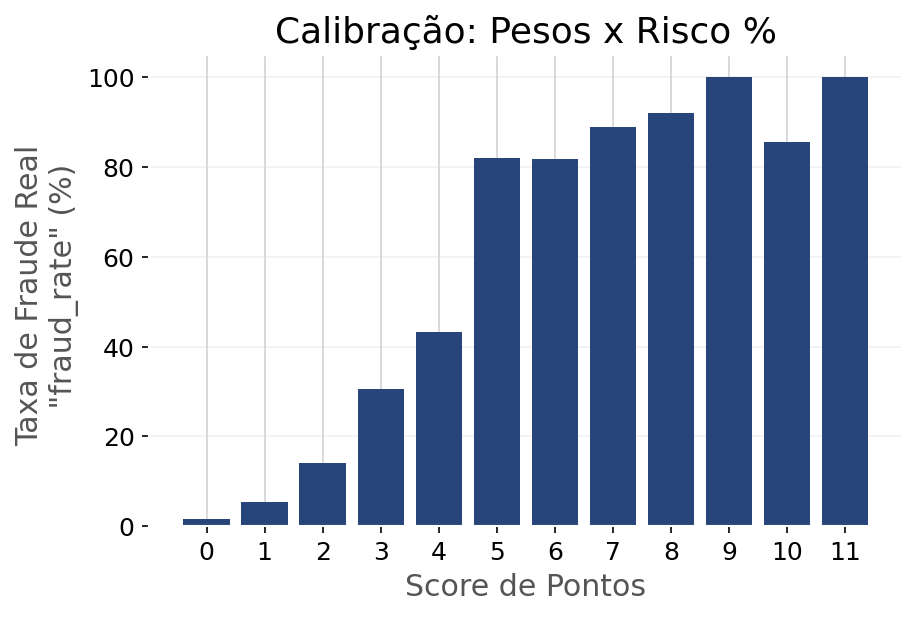

In [17]:
fig, axes = plt.subplots(figsize=(6, 4))

taxa_por_score = df.groupby('weight_score')['has_cbk'].mean() * 100
axes.bar(taxa_por_score.index, taxa_por_score.values, color='#27457B')
axes.set_xlabel('Score de Pontos')
axes.set_ylabel('Taxa de Fraude Real \n "fraud_rate" (%)')
axes.set_title('Calibração: Pesos x Risco %')
axes.set_xticks(range(len(agg_table)))
axes.grid(axis='y', alpha=0.3)

---

💡 **Insights:** `Distribuição do Score`

A distribuição dos scores mostra que o sistema criado está coerente e alinhado com o comportamento real das transações. Dessa forma, podemos destacar alguns padrões importantes:

- Concentração de transações legítimas em scores baixos:\
  A grande maioria das operações possui score 0, com taxa de fraude de apenas 1,5%, o que confirma que o modelo não está sinalizando falsos positivos de forma excessiva.

- Aumento progressivo da taxa de fraude conforme o score cresce:\
  A relação entre score e risco é monotônica, exatamente o comportamento desejado em um sistema de pontuação manual.

- Scores altos são predominantemente fraudulentos:\
  A partir do score 5, a presença de transações legítimas diminui drasticamente.

- Baixa representatividade de scores muito altos (≥8):\
  Essas faixas possuem poucas transações, mas contam com altíssimas taxas de fraude (90%–100%), reforçando sua utilidade na identificação de casos críticos.

- Distribuição saudável e sem distorções:\
  O score não ficou “congestionado” em poucas faixas nem excessivamente disperso, o que facilita a criação de thresholds operacionais.
---

### **5.2.2 Categorização em níveis de risco**

In [26]:
print("─"*70)
print("PERFORMANCE POR CATEGORIA")
print("─"*70)

agg_table['score_range'] = pd.cut(agg_table['score'], 
                                       bins=[0, 1, 4, 7, 13],
                                       labels=['0-1', '2-4', '5-7', '8-13'], include_lowest=True) 
                                              

cat_scores = agg_table.groupby('score_range', observed=True).agg({
    'n_transactions': 'sum',
    'relative_freq': 'sum',
    'n_frauds': 'sum',	
}).round(1).reset_index()

cat_scores['fraud_rate'] = ((cat_scores['n_frauds'] * 100) / cat_scores['n_transactions']).round(1)

action_dict = {'action': ['Liberar', 'Revisar', 'Bloquear*', 'Bloquear']}
cat_scores['action'] = pd.DataFrame(action_dict)

cat_scores

──────────────────────────────────────────────────────────────────────
PERFORMANCE POR CATEGORIA
──────────────────────────────────────────────────────────────────────


,score_range,n_transactions,relative_freq,n_frauds,fraud_rate,action
0,0-1,2647,82.8,85,3.2,Liberar
1,2-4,304,9.6,91,29.9,Revisar
2,5-7,176,5.6,148,84.1,Bloquear*
3,8-13,72,2.3,67,93.1,Bloquear


Após calcular o score de risco para todas as transações, agrupamos os resultados em faixas para identificar padrões operacionais.\
A análise mostra que cada faixa de score apresenta comportamento distinto de volume e taxa de fraude, permitindo definir quatro níveis de ação.

Com base nesses marcos, definimos as seguintes categorias:

**Score 0–1 — Baixo Risco (Liberar)**

- Maioria absoluta das transações, com baixíssima taxa de fraude.
- Fluxo ideal: aprovação automática, mantendo excelente experiência do usuário.

**Score 2–4 — Risco Moderado (Revisar)**

- Volume reduzido, mas taxa de fraude já atinge ~30%.
- Fluxo ideal: revisão leve ou verificação adicional (ex.: autenticação 2FA).

**Score 5–7 — Alto Risco (Bloquear * )**

- Faixa intermediária, porém com fraudes acima de 80%.
- Fluxo ideal: bloqueio preventivo, podendo liberar após confirmação do usuário.
- O asterisco indica que parte desses casos pode ser tratada com verificação adicional.

**Score 8–13 — Risco Crítico (Bloquear)**

- Transações extremamente suspeitas, com ~93% de fraude.
- Fluxo ideal: bloqueio automático e investigação.

Dessa forma, a categorização permite transformar o score em decisões operacionais claras, priorizando segurança sem sacrificar a experiência do usuário.

# 6. Avaliação de Performance

Nesta seção iremos avaliar a eficácia do score manual sob três perspectivas complementares:

- **Métricas de classificação**: Acurácia, especificidade, taxa FP, sensibilidade, precisão, F1-score.
- **Análise dos erros**: Por meio da matriz de confusão, identificando onde o modelo acerta e onde falha.
- **Validação com Machine Learning**: Comparando a performance e os pesos aprendidos pela Regressão Logística com o nosso sistema de pontuação manual.

Essa etapa confirma se o score é robusto, consistente e competitivo em relação a um modelo estatístico, garantindo confiança para avançar para a calibração econômica.

## 6.1. Métricas de Performance

In [19]:
tab = thr.analyze_thresholds(df, range(0, 14), target_col='has_cbk', score_col='weight_score')
tab_pct = thr.display_threshold_table(tab)
tab_pct

,threshold,transacoes_bloqueadas,fraudes_detectadas,acuracia_pct,especificidade_pct,taxa_fp_pct,sensibilidade_pct,precisao_pct,f1_pct
0,0,3199,391,12.2%,0.0%,100.0%,100.0%,12.2%,21.8%
1,1,1741,369,56.4%,51.1%,48.9%,94.4%,21.2%,34.6%
2,2,552,306,89.7%,91.2%,8.8%,78.3%,55.4%,64.9%
3,3,460,293,91.7%,94.1%,5.9%,74.9%,63.7%,68.9%
4,4,352,260,93.0%,96.7%,3.3%,66.5%,73.9%,70.0%
5,5,248,215,93.5%,98.8%,1.2%,55.0%,86.7%,67.3%
6,6,192,169,92.3%,99.2%,0.8%,43.2%,88.0%,58.0%
7,7,126,115,91.0%,99.6%,0.4%,29.4%,91.3%,44.5%
8,8,72,67,89.7%,99.8%,0.2%,17.1%,93.1%,28.9%
9,9,22,21,88.4%,100.0%,0.0%,5.4%,95.5%,10.2%


---

💡 **Insights:** `Métricas de Performance`

A análise das métricas confirma que o score manual apresenta comportamento esperado e robusto.
- O threshold 4 maximiza o F1-score (70%), oferecendo o melhor equilíbrio entre capturar fraudes e evitar falsos positivos.
- Thresholds mais baixos capturam mais fraudes às custas de bloquear clientes legítimos, enquanto thresholds mais altos reduzem drasticamente a sensibilidade.

Essas observações corroboram com a definição das categorias de risco na etapa anterior.

---

## 6.2. Matriz de Confusão

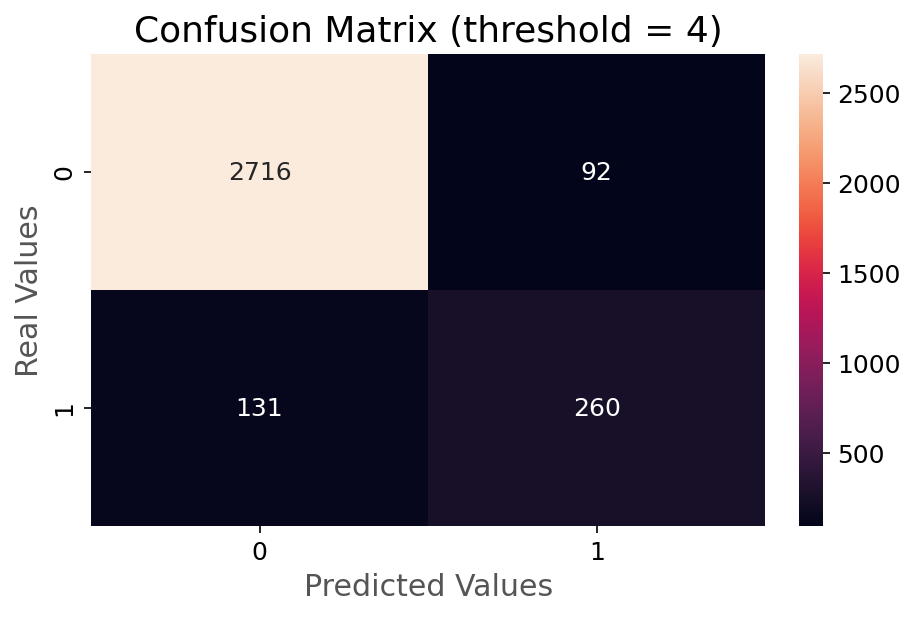

In [20]:
confusion_matrix_4 = thr.plot_confusion_matrix(df, threshold=4, target_col='has_cbk', score_col='weight_score')

---

💡 **Insights:** `Matriz de Confusão`

- **Verdadeiros Positivos (260 fraudes detectadas)**: O modelo identifica corretamente uma parcela significativa das fraudes.

- **Falsos Negativos (131 fraudes não detectadas)**: Fraudes que escapam do sistema mesmo com o "threshold ótimo".

- **Falsos Positivos (92 transações legítimas bloqueadas)**: Representam fricção ao cliente. Esse volume ainda é considerado aceitável, dado o ganho em detecção.

- **Verdadeiros Negativos (2716 transações legítimas liberadas)**: Mostram que o sistema mantém uma boa experiência para a maioria dos usuários.

Threshold 4 equilibra sensibilidade e precisão, reduzindo falsos positivos sem perder muita capacidade de detectar fraudes.

---

## 6.3. Validação com Machine Learning

Nessa etapa, utilizaremos a Regressão Logística, um modelo estatístico simples e interpretável, treinado com as mesmas features usadas no score manual.\
A comparação entre os dois métodos permite avaliar:

- Consistência dos pesos: pesos manuais × coeficientes do modelo.
- Desempenho geral: F1-score, precisão, recall.
- Coerência estrutural: se ambos chegam às mesmas conclusões sobre o que aumenta o risco.

Se a Regressão Logística apresentar coeficientes alinhados aos pesos definidos e performance semelhante, isso indica que:

- O score manual é bem fundamentado.
- Captura os padrões essenciais do modelo estatístico.
- Permanece mais simples, interpretável e auditável para uso operacional.

In [21]:
feature_cols = [
    'user_fraud_above_50',
    'multi_card_flag',
    'multi_device_flag',
    'burst_transaction',
    'comb_a',
    'value_exc_max',
    'anomalous_value',
    'nighttime_flag'
]

X = df[feature_cols]
y = df['has_cbk']

# Treinar Regressão Logística
log_reg = LogisticRegression(
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
)

log_reg.fit(X, y)


# Criar DataFrame
coefs = pd.DataFrame({
    'feature': feature_cols,
    'coef_logit': log_reg.coef_[0],
})

# Normalização dos coeficientes da Regressão Logística
coefs['coef_logit_norm'] = (1 + 2 * ((coefs['coef_logit'] - coefs['coef_logit'].min()) / (coefs['coef_logit'].max() - coefs['coef_logit'].min()))).round(2)

# Inserir coluna 'weight_score_manual_ajustado'
stats_log_reg = pd.merge(coefs, stats_df[['feature', 'weight_score_manual_ajustado']], on='feature', how='inner')
stats_log_reg['diff'] = stats_log_reg['coef_logit_norm'] - stats_log_reg['weight_score_manual_ajustado']

# Ordenar da maior influência positiva para a menor
stats_log_reg = stats_log_reg.sort_values('coef_logit', ascending=False).reset_index(drop=True)

stats_log_reg

,feature,coef_logit,coef_logit_norm,weight_score_manual_ajustado,diff
0,user_fraud_above_50,3.856904,3.00,3,0.00
1,burst_transaction,2.114673,2.11,2,0.11
2,anomalous_value,1.947833,2.03,1,1.03
3,multi_card_flag,1.606043,1.85,2,-0.15
4,nighttime_flag,0.818673,1.45,1,0.45
5,value_exc_max,0.661115,1.37,1,0.37
6,comb_a,0.322042,1.20,2,-0.80
7,multi_device_flag,-0.068883,1.00,1,0.00


---

💡 **Insights:** `Pesos da Regressão Logística`

- Os pesos manuais (RR + IV + correlação) convergiram fortemente com os pesos estimados pelo modelo de Regressão Logística após normalização.
- A média de diferença absoluta entre os pesos foi baixa, indicando que o score é interpretável, rastreável e estatisticamente coerente.
- As divergências pontuais destacam oportunidades de ajuste fino, mas reforçam que a estrutura geral do score é robusta e alinhada ao comportamento real das fraudes.

---

### **6.3.1. Métrica ROC AUC**

Iremos incluir a métrica ROC AUC porque ela avalia a capacidade do modelo de ordenar transações fraudulentas e legítimas independentemente do threshold.\
Isso é particularmente relevante no nosso projeto, onde a comparação principal é entre:

- Um score manual baseado em RR + IV + correlação
- Um modelo estatístico (Regressão Logística)

AUC nos permite verificar se ambos chegam a rankings semelhantes, mesmo que os thresholds ótimos sejam diferentes.

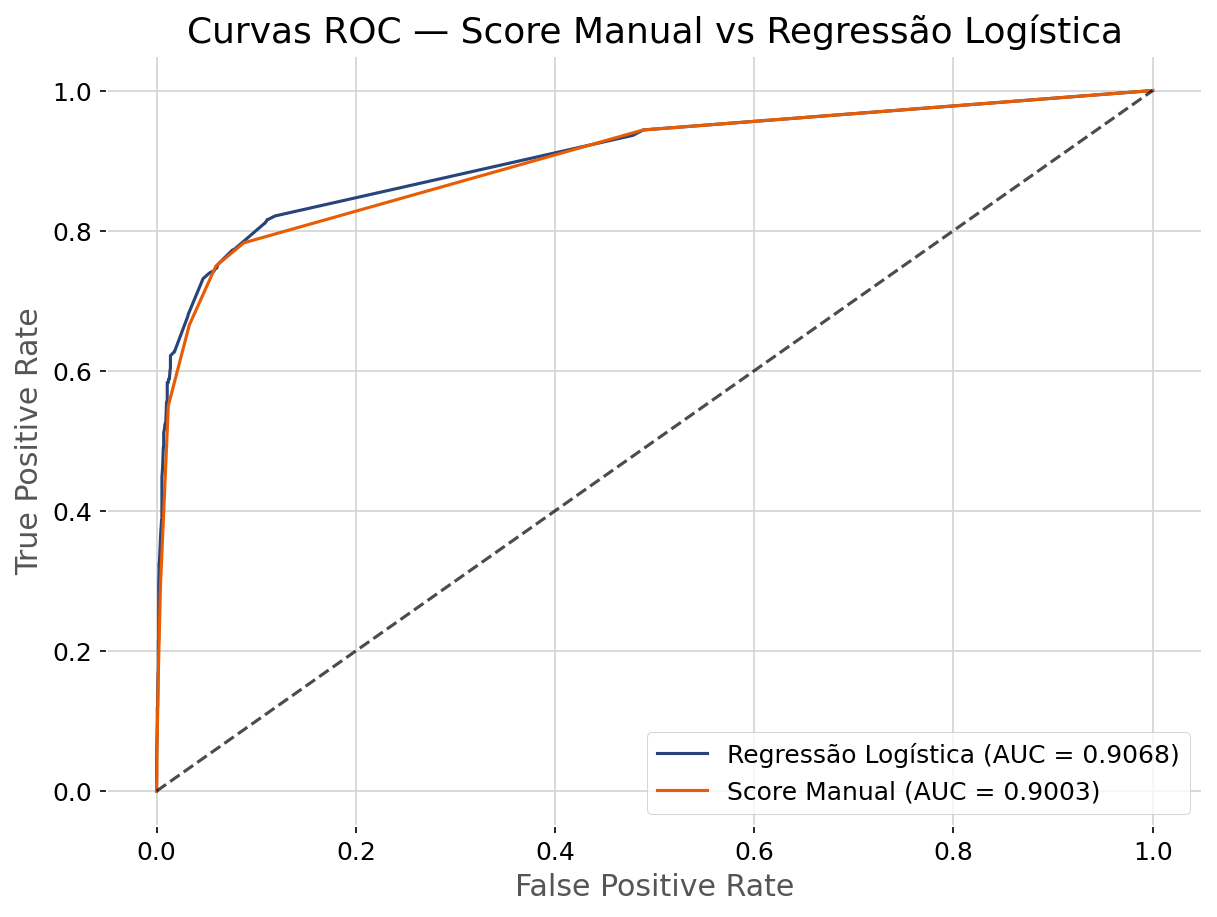

In [31]:
y_true = df['has_cbk']
y_score_manual = df['weight_score']
y_score_logit = log_reg.predict_proba(X)[:, 1]

fpr_m, tpr_m, _ = roc_curve(y_true, y_score_manual)
fpr_l, tpr_l, _ = roc_curve(y_true, y_score_logit)

auc_manual = auc(fpr_m, tpr_m)
auc_logit  = auc(fpr_l, tpr_l)

plt.figure(figsize=(8,6))
plt.plot(fpr_l, tpr_l, label=f'Regressão Logística (AUC = {auc_logit:.4f})')
plt.plot(fpr_m, tpr_m, label=f'Score Manual (AUC = {auc_manual:.4f})')

plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC — Score Manual vs Regressão Logística")
plt.legend()
plt.grid(True)
plt.savefig('curvas_roc_score_manual_x_regressao_logistica.png', dpi=300)
plt.show()


In [23]:
y_true = df['has_cbk']
y_pred_proba = log_reg.predict_proba(X)[:, 1]

auc_ml = roc_auc_score(y_true, y_pred_proba)
print(f'AUC - Regressão Logística: {auc_ml:.4f}')

score_norm = df['weight_score'] / df['weight_score'].max()
auc_manual = roc_auc_score(y_true, score_norm)

print(f'AUC - Score Manual: {auc_manual:.4f}')

AUC - Regressão Logística: 0.9068
AUC - Score Manual: 0.9003


---

💡 **Insights:** `Métrica ROC AUC`

Avaliamos a performance global dos modelos através da métrica AUC (Area Under the ROC Curve), que mede a capacidade de distinguir fraudes de transações legítimas independentemente de thresholds.

A Regressão Logística atingiu AUC = 0.9068, enquanto o score manual alcançou AUC = 0.9003, uma diferença de apenas 0.0065.

Essa proximidade mostra que a construção manual dos pesos, guiada por evidências (RR, IV, correlação e análise comportamental), capturou praticamente o mesmo grau de separabilidade que o modelo estatístico treinado.

Em outras palavras: o score manual é simples, interpretável e alcança desempenho equivalente ao modelo supervisionado, reforçando sua validade e justificando seu uso em cenários de baixo volume de dados ou onde interpretabilidade é essencial.

---

# 7. Calibração Econômica

Nesta etapa iremos realizar a Calibração Econômica do score, avaliando os thresholds do Score Manual e medindo, para cada um, o impacto financeiro líquido da decisão de bloqueio.

Cada threshold representa uma política operacional: “bloquear transações com score ≥ X”.

Para cada política, medimos tanto as métricas de performance (TP, FP, FN) quanto seu efeito financeiro direto, combinando:

- Economia por fraudes evitadas;
- Custos de falsos positivos;
- Custos de falsos negativos;

O objetivo é determinar qual threshold maximiza o lucro líquido esperado, um dos critérios usados em bancos, fintechs e times antifraude.

## 7.1. Lógica de Construção da Tabela de Impacto Financeiro

1. **Cálculo Financeiro para Contexto de Fraude**

Iremos expressar a performance do modelo em termos de impacto financeiro, usando as métricas da matriz de confusão (TP, FP, FN, TN) e o valor financeiro que cada uma representa.

Não temos o custo exato de cada fraude, então vamos trabalhar com suposições razoáveis, típicas de meios de pagamento:

`TP`: Fraude Detectada Corretamente.
- Evitamos perda por chargeback.
- Iremos utilizar a média dos valores das transações fraudulentas do dataset para simplificação.

`FP`: Legítima Bloqueada Incorretamente.
- Perda de receita (compra não realizada).
- Risco de churn, reclamação e custo de suporte.
- Para estimar isso, podemos assumir que um falso positivo custa 10% do valor da transação (perda de margem + atrito).
- Iremos utilizar a média dos valores das transações legítimas do dataset para simplificação.

`FN`: Fraude Liberada Incorretamente.
- Reembolsa o valor da transação ao cliente vítima.
- Arca com taxas de chargeback e custos operacionais.
- Para simplificar, podemos assumir que o custo total de uma fraude é 120% do valor da transação.
- Iremos utilizar a média dos valores das transações fraudulentas do dataset para simplificação.

`TN`: Legítima Liberada Corretamente.
- Transação flui sem atrito.
- Cliente satisfeito (retenção).
- Não há custo operacional.

2. **Restrição de operação**: Iremos filtrar apenas thresholds com taxa_fp_pct ≤ 5%.
   
   Em bancos e fintechs, taxas acima de 5%:

- Impacta negativamente a experiência do cliente, causando bloqueios indevidos e perda de receita.
- Gera "fadiga de alertas" nos analistas, aumentando o custo operacional.
- Afeta negativamente a reputação da instituição, gerando perda de confiança no sistema.

---

Dessa forma, para cada threshold possível (score ≥ X), teremos os seguintes dados:

3. **Métricas de Performance**:

- `TP`: Número de fraudes bloqueadas corretamente.
- `FP`: Número de clientes legítimos bloqueados incorretamente.
- `FN`: Número de fraudes liberadas incorretamente.
- `TN`: Número de clientes legítimos liberados corretamente.

4. **Impacto Financeiro do Threshold**:

- `TP_saving`: Economia gerada por uma fraude bloqueada corretamente.
- `FP_cost`: Custo reputacional/operacional de bloquear cliente legítimo incorretamente.
- `FN_cost`: Custo direto de deixar uma fraude passar.
- `net_profit`: `TP` - `FP` - `FN`.
- `vs. baseline (no score)`: Lucro líquido quando comparado ao Baseline (cenário sem uso do score: todas fraudes passam)

## 7.2 Construção da Tabela de Impacto Financeiro

In [24]:
TP_saving_mean = df[df['has_cbk'] == 1]['transaction_amount'].mean()
FP_cost_mean = (df[df['has_cbk'] == 0]['transaction_amount'].mean())*0.15
FN_cost_mean = (df[df['has_cbk'] == 1]['transaction_amount'].mean())*1.20

print(f'TP_saving_mean: {TP_saving_mean:.2f}')
print(f'FP_cost_mean: {FP_cost_mean:.2f}')
print(f'FN_cost_mean: {FN_cost_mean:.2f}')

TP_saving_mean: 1453.57
FP_cost_mean: 100.85
FN_cost_mean: 1744.29


In [25]:
economic_table = thr.economic_calibration(df,
                                  thresholds=range(0, 14),
                                  target_col='has_cbk',
                                  score_col='weight_score',
                                  saving_per_TP=TP_saving_mean, 
                                  cost_per_FP=FP_cost_mean,
                                  cost_per_FN=FN_cost_mean)

economic_table['vs. baseline (no score)'] = economic_table['net_profit'] - (-FN_cost_mean*391)

economic_table = pd.merge(economic_table, tab[['threshold', 'taxa_fp_pct']], on='threshold', how='inner')
economic_table.round(2)

,threshold,TP,FP,FN,TN,TP_saving,FP_cost,FN_cost,net_profit,vs. baseline (no score),taxa_fp_pct
0,0,391,2808,0,0,568346.62,283183.03,0.00,285163.59,967179.53,100.0
1,1,369,1372,22,1436,536368.04,138364.36,38374.30,359629.38,1041645.33,48.9
2,2,306,246,85,2562,444793.01,24808.77,148264.34,271719.90,953735.85,8.8
3,3,293,167,98,2641,425896.57,16841.73,170940.06,238114.79,920130.73,5.9
4,4,260,92,131,2716,377928.70,9278.08,228501.51,140149.12,822165.06,3.3
5,5,215,33,176,2775,312517.96,3328.01,306994.39,2195.57,684211.51,1.2
6,6,169,23,222,2785,245653.65,2319.52,387231.56,-143897.42,538118.52,0.8
7,7,115,11,276,2797,167160.77,1109.34,481423.02,-315371.58,366644.36,0.4
8,8,67,5,324,2803,97389.32,504.24,565148.76,-468263.69,213752.26,0.2
9,9,21,1,370,2807,30525.01,100.85,645385.93,-614961.77,67054.17,0.0


Avaliamos todos os thresholds possíveis para o Score Manual, medindo tanto a performance estatística quanto o impacto financeiro líquido gerado por cada política de bloqueio.

O threshold ótimo é aquele que maximiza o lucro líquido considerando: O cálculo Financeiro para o contexto de fraude e a restrição de operação, regras criadas na seção 7.1.

---

💡 **Insights:** `Impacto Financeiro`

- Thresholds mais baixos aumentam detecção, mas geram custo excessivo com falsos positivos.
- Thresholds mais altos reduzem atrito, mas deixam passar fraudes, gerando impacto no resultado.
- O threshold ≥ 4 representa o ponto ótimo sob perspectiva econômica, pois apresenta o melhor equilíbrio entre detecção, controle de falsos positivos e retorno financeiro, seguindo os parâmetros adotados previamente na análise.

Comparado ao cenário sem score, o threshold ≥ 4 gera:

- **Economia com fraudes bloqueadas:** `+R$ 377.928`
- **Custo com falsos positivos:** `−R$ 9.278`
- **Perda com fraudes não detectadas:** `−R$ 228.501`
- **Lucro líquido incremental:** `+R$ 140.149`

- **Melhoria vs. baseline (sem score):** **`+R$ 822.165`** em redução total de perdas.

---

# Conclusão: Criação do Score de Risco e Avaliação

Neste notebook, transformamos os insights exploratórios e as features validadas nas etapas anteriores em um sistema de score de risco transparente, interpretável e orientado a valor.

Iniciamos com a definição dos pesos, combinando três métricas complementares:

- Risco Relativo (RR) para capturar impacto;
- Information Value (IV) para medir poder discriminativo;
- Análise de correlação para evitar redundância;

Essa abordagem evidenciou que atribuir pesos apenas com base em um critério não é suficiente, reforçando a necessidade de uma lógica mais robusta e balanceada na construção de scores manuais.

Em seguida, aplicamos o score às transações, analisando sua distribuição, comportamento por faixa e categorização em níveis operacionais de risco, conectando diretamente métricas estatísticas a decisões reais como liberar, revisar ou bloquear transações.

Na etapa de avaliação de performance, demonstramos que o score manual alcança resultados sólidos, com bom equilíbrio entre sensibilidade e precisão, e performance próxima à de uma Regressão Logística, validada por métricas como F1-Score e ROC AUC. Essa convergência confirma que a lógica construída manualmente está alinhada ao aprendizado estatístico, preservando interpretabilidade e controle.

Por fim, a calibração econômica mostrou-se decisiva: ao avaliar todos os thresholds possíveis sob a ótica financeira, identificamos que o valor ótimo não é definido apenas por métricas técnicas, mas pelo impacto econômico líquido gerado. O score demonstrou capacidade de reduzir perdas de forma significativa em relação ao baseline sem score, gerando uma economia de até `+R$ 822.165`, validando sua viabilidade prática.

Dessa forma, este trabalho consolida a ponte entre análise exploratória, engenharia de features, modelagem de risco e impacto financeiro, encerrando o ciclo analítico atigindo os objetivos e critérios de sucesso firmados no inicio do projeto.

# Conclusão do Projeto

Neste projeto, desenvolvi um sistema de Score de Risco para detecção de fraudes em transações bancárias, partindo de uma análise exploratória aprofundada até a construção, validação e calibração econômica de um score manual viável.

Ao longo do trabalho, foi possível identificar padrões claros de comportamento fraudulento, traduzi-los em features explicáveis, e consolidá-los em um score baseado em Risco Relativo, Information Value e controle de correlação, garantindo coerência estatística e evitando redundâncias. A validação com Regressão Logística mostrou forte convergência entre os pesos manuais e os coeficientes do modelo, reforçando que o score não é arbitrário, mas fundamentado em evidências.

A avaliação de performance demonstrou boa capacidade discriminativa (AUC ~0,90), com métricas equilibradas entre detecção e controle de falsos positivos. Mais importante, a calibração econômica revelou que a escolha do threshold baseada em valor financeiro gera impacto real, com redução significativa de perdas quando comparada ao cenário sem score.

Os resultados indicam que um score manual bem construído pode ser tão eficaz quanto modelos estatísticos mais complexos em contextos de dados limitados, oferecendo vantagens claras em interpretabilidade, rastreabilidade e governança, aspectos críticos em ambientes regulados como o setor financeiro.

O projeto resolve o problema de negócio proposto ao transformar dados em decisões acionáveis, demonstrando que a combinação de análise estatística, visão de negócio e avaliação econômica é capaz de gerar valor mensurável, escalável e financeiramente justificável.